In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

import seaborn as sns

plt.style.use('seaborn')

import nltk
import string
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_df.shape

(7613, 5)

In [5]:
train_df.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

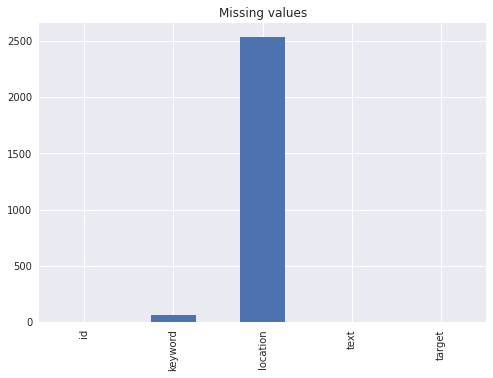

In [6]:
train_df.isnull().sum().plot(kind='bar')
plt.title("Missing values")
plt.show()

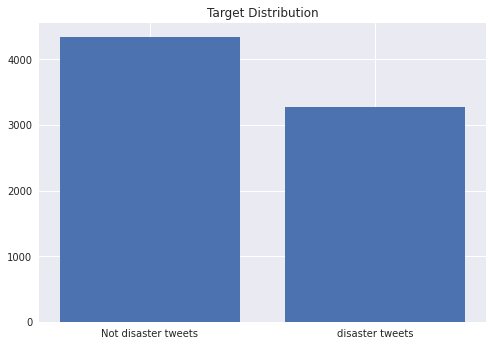

In [7]:
target_count = train_df.groupby('target').size().reset_index(name='counts')
plt.bar(target_count.target, target_count.counts)
plt.xticks([0,1], labels=["Not disaster tweets", "disaster tweets"])
plt.title("Target Distribution")
plt.show()

In [8]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

ps = PorterStemmer()

eng_stopwords = set(stopwords.words('english'))

def preprocess_text(val):
    # convert to lower case
    val = val.lower()
    
    val = re.sub(r"http\S+", "", val)
    
    # remove punctuations
    val = "".join([c for c in val if c not in string.punctuation])
    
    # remove digits
    val = re.sub(r"\d", " ", val)
    
    # remove mulitple whitespaces into single
    val = re.sub(r"\s+", " ", val)
    
    # TODO: Should use NLTK's lemmatization
    
    tokens = nltk.word_tokenize(val)

    tokens = [t for t in tokens if t not in eng_stopwords]
    
    tokens = [ps.stem(t) for t in tokens]
    
    return ' '.join(tokens)

In [9]:
train_df['clean_text'] = train_df.text.apply(preprocess_text)


In [10]:
train_df['clean_text_len'] = train_df.clean_text.apply(lambda x:len(x))

In [11]:
train_df.head()

,id,keyword,location,text,target,clean_text,clean_text_len
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us,41
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada,36
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...,69
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,peopl receiv wildfir evacu order california,43
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...,52


In [12]:
train_df.describe()

,id,target,clean_text_len
count,7613.000000,7613.00000,7613.000000
mean,5441.934848,0.42966,57.531197
std,3137.116090,0.49506,22.138020
min,1.000000,0.00000,3.000000
25%,2734.000000,0.00000,41.000000
50%,5408.000000,0.00000,58.000000
75%,8146.000000,1.00000,74.000000
max,10873.000000,1.00000,127.000000


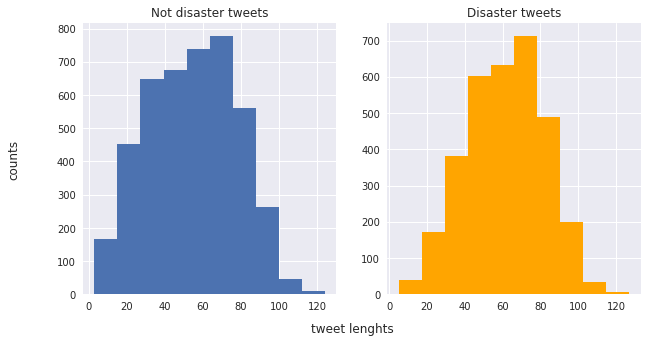

In [13]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(train_df['clean_text_len'][train_df.target==0])
plt.title("Not disaster tweets")

plt.subplot(1,2,2)
plt.hist(train_df['clean_text_len'][train_df.target==1], color='orange')
plt.title("Disaster tweets")

fig.supxlabel("tweet lenghts")
fig.supylabel("counts")
plt.show()

In [14]:
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# from sklearn.preprocessing import Normalizer

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df.clean_text, train_df.target, test_size=0.20, random_state=42)

In [16]:
vectorizer = TfidfVectorizer(max_features=8000, ngram_range=(1,1))

# vectorizer.fit(train_df.clean_text)
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_valid = vectorizer.transform(X_valid)

In [17]:
from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier # , GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

# from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [18]:
models = [  
    {
        'name' : 'Light GBM Classifier',
        'estimator' : LGBMClassifier(),
        'params' : {'n_estimators': (50, 100, 150, 200, 500)}
    }, 
    {
        'name' : 'Random Forest Classifier',
        'estimator' : RandomForestClassifier(),
        'params' : {'n_estimators':(10, 50, 100, 150, 200)}
    },
]

In [19]:
best_estimators = {}
for model in models:
    search = GridSearchCV(model['estimator'], param_grid=model['params'], verbose=1, n_jobs=3)
    search.fit(X_train, y_train)
    score = search.best_estimator_.score(X_valid, y_valid)
    best_estimators[model['name']] = search.best_estimator_
    print("-------------------------------------")
    print("Model:", model["name"], ", Score:", score)
    for param, mean_score, std_score in zip(search.cv_results_['params'], 
                                                search.cv_results_['mean_test_score'], 
                                                search.cv_results_['std_test_score']):
        print(f"{param}, {mean_score:.5f}, (-/+ {std_score:.5f})")
        

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  25 out of  25 | elapsed:   15.4s finished


-------------------------------------
Model: Light GBM Classifier , Score: 0.7747866053841103
{'n_estimators': 50}, 0.76913, (-/+ 0.00109)
{'n_estimators': 100}, 0.76716, (-/+ 0.00339)
{'n_estimators': 150}, 0.76667, (-/+ 0.00141)
{'n_estimators': 200}, 0.76338, (-/+ 0.00468)
{'n_estimators': 500}, 0.76141, (-/+ 0.00694)
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  25 out of  25 | elapsed:  1.9min finished


-------------------------------------
Model: Random Forest Classifier , Score: 0.7852921864740644
{'n_estimators': 10}, 0.76667, (-/+ 0.00699)
{'n_estimators': 50}, 0.77980, (-/+ 0.01054)
{'n_estimators': 100}, 0.78095, (-/+ 0.00633)
{'n_estimators': 150}, 0.78030, (-/+ 0.00824)
{'n_estimators': 200}, 0.78539, (-/+ 0.00931)


In [20]:
best_model = best_estimators['Random Forest Classifier']
best_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [21]:
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
test_df['clean_text'] = test_df.text.apply(preprocess_text)
X_test = vectorizer.transform(test_df.clean_text)

In [22]:
scores = best_model.predict(X_test)

In [23]:
scores[:20]

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0])

In [24]:
submit_df = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submit_df.target = scores
submit_df.to_csv("submission.csv", index=False)